In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import joblib
import h5py 
import os

2023-11-24 16:03:33.725231: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Diabetic retinopathy, a complication associated with diabetes, affects the eys and can lead to blindness if not diagnosed. This condition rsults from damage to the blood vessels inside the retina. Diabetic retinopathy is a leading cause of blindness among adults.

The goal of this project is to implement a machine learning model that can accurately predict the presence of diabetic retinopathy using retinal images.We will be using the [diabetic retinopathy](https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized/) dataset from kaggle, consisting of over 35,000 1024x1024 retinal scans. Below is an example of an individual retinal scan.

# How to install?


I highly recommend using a python environment solution like [miniconda](https://docs.conda.io/projects/miniconda/en/latest/miniconda-install.html)

This guide will presume you're using a Linux or Mac OS.

We will first need to create a conda environment: using `conda create <env name>`.

Activate the conda environment with `conda activate <env name>`.

We will not install our packages, first run `conda install tensorflow-gpu`, secondly run `conda install jupyter pandas=1.5.2 numpy=1.20.3 matplotlib scikit-learn h5py`.

We will be using [this dataset](https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized/). The jupyter notebook in this repo is formatted

In [6]:
import numpy as np
import pandas as pd

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)

NumPy version: 1.20.3
Pandas version: 1.5.2


Diabetic retinopathy, a complication associated with diabetes, affects the eys and can lead to blindness if not diagnosed. This condition rsults from damage to the blood vessels inside the retina. Diabetic retinopathy is a leading cause of blindness among adults.

The goal of this project is to implement a machine learning model that can accurately predict the presence of diabetic retinopathy using retinal images.We will be using the [diabetic retinopathy](https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized/) dataset from kaggle, consisting of over 35,000 1024x1024 retinal scans. Below is an example of an individual retinal scan.

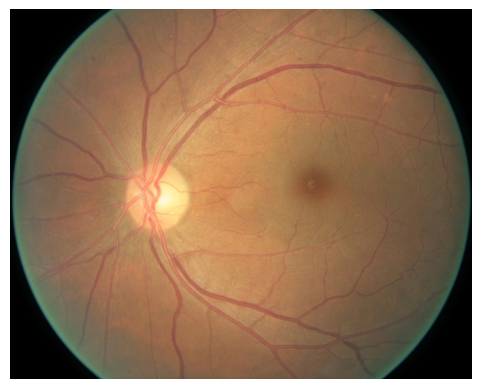

In [5]:
def plot_image(path):
    img = Image.open(path)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
plot_image('./dataset/resized_train_cropped/34035_right.jpeg')

We will begin by preprocessing all images in the dataset. Normalization involves converting the .jpeg file into a $m \times n$ dimensional array. The `normalize()` function converts the elements of the array into 16 bit floating point variables between the value of 0 and 1.

In [4]:
def normalize(path):
    
    """ Normalize an image by resizing and scaling pixel values """
    
    # open image and ensure size is 1024x1024
    img = Image.open(path).resize((1024, 1024))
    # normalize as 16 bit float between 0 and 1
    array = np.array(img).astype(np.float16) / 255.0
    
    return array

The function below uses a `ImageDataGenerator` to augment a single image per call to `augment()`. The goal of augmentation is to artificially increase diversity in a training set.

In [6]:
# ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range = 20,          # rotate by n degrees
    width_shift_range = 0.2,      # horizontal shift
    height_shift_range = 0.2,     # vertical shift
    shear_range = 0.2,            # shear transform
    zoom_range = 0.2,             # zoom in or out
    horizontal_flip = True,       # flip horizontally?
    fill_mode = 'nearest'         # fill method for new pixels
)

def augment(image, datagen):
    
    """ Augment image using above ImageDataGenerator """
    
    # add dimension for fit
    img = np.expand_dims(image, 0)

    # create generator
    it = datagen.float(img, batch_size = 1)
    
    # augment one image
    augmented = next(it)[0].astype(np.float16)
    
    return augmented

The `process_image()` function just calls the `augment()` and `normalize()` functions and returns an exception if anything is wrong.

In [7]:
def process_image(path):
    
    """ Process singular image given path """
    
    # try to preprocess
    try:
        array = normalize(path)
        array = augment(array, datagen)
        
        return augmented
    
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

Instead of having to preprocess the dataset everytime the notebook is run, the `create_cache()` function checks if a preprocessed version of the dataset has been made already. If not, it creates a cache file. The code is written to be as parallel as possible to ensure preprocessing is quick.

In [8]:
def create_cache(images_directory, cache_path, batch_size=100):
    
    """ Create preprocessed cache """
    if not os.path.exists(cache_path):
        # list all JPEG images in directory
        image_paths = [os.path.join(images_directory, f) for f in os.listdir(images_directory) if f.endswith('.jpeg')]
        
        # Init HDF5 file and create thread pool
        with h5py.File(cache_path, 'w') as h5file, ThreadPoolExecutor() as executor:  
            for i in range(0, len(image_paths), batch_size):
                # get batch of image paths
                batch_paths = image_paths[i:i+batch_size]  
                # process images in parallel
                batch_cache = list(executor.map(process_image, batch_paths))  

                # add dataset in HDF5 file from batch
                h5file.create_dataset(f'batch_{i//batch_size}', data=batch_cache)
                print(f'\rProcessed {i + len(batch_cache)} out of {len(image_paths)}', end='')  

        print("\nCache file created.")  
    else:
        print("Cache file already exists.")